In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper
from psiam_tied_dv_map_utils import cum_A_t_fn, cum_E_t_fn, down_RTs_fit_TRUNC_fn, up_RTs_fit_TRUNC_fn
from psiam_tied_dv_map_utils import psiam_tied_data_gen_wrapper_V4, psiam_tied_data_gen_wrapper_V2
from psiam_tied_no_dv_map_utils import rho_E_minus_small_t_NORM_fn
from diagnostics_class import Diagnostics

In [2]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

vp_sample = vp.sample(int(1e6))[0]

V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04

t_A_aff = np.mean(vp_sample[:,2]) - t_motor


with open('right_trunc_with_aborts.pkl', 'rb') as f:
    vp_trunc = pickle.load(f).vp

vp_samples_trunc = vp_trunc.sample(int(1e6))[0]


rate_lambda = np.mean(vp_samples_trunc[:,0])

T0 = np.mean(vp_samples_trunc[:,1]) 

theta_E = np.mean(vp_samples_trunc[:,2])
t_E_aff = np.mean(vp_samples_trunc[:,3])
Z_E = np.mean(vp_samples_trunc[:,4])

In [3]:
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# design diagnosis

In [10]:
T_0_tau = 0.2
N_sim = int(50e3)
dt = 1e-3; dB = np.sqrt(dt);
t_stim_sampled = np.random.choice(df['intended_fix'], N_sim)
N_print = N_sim + 1
L = 0.3

In [11]:
sim_results_base = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                                                                    t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 


In [12]:

sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V4)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T0, T_0_tau, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 


In iter_num: 0, ABL: 60, ILD: 16.0, t_stim: 0.50007121874582


In [13]:
# sim - changing tau
for d in sim_results:
    d['correct'] = 1 if d['ILD'] * d['choice'] > 0 else 0

# all trials df
sim_results_pd_valid = pd.DataFrame(sim_results)
# only valid trials df
sim_results_pd_valid_1 = sim_results_pd_valid[sim_results_pd_valid['rt'] > sim_results_pd_valid['t_stim']]

sim_diagnose_obj = Diagnostics(sim_results_pd_valid)
sim_diagnose_obj_valid = Diagnostics(sim_results_pd_valid_1)



for d in sim_results_base:
    d['correct'] = 1 if d['ILD'] * d['choice'] > 0 else 0

sim_results_base_pd_valid = pd.DataFrame(sim_results_base)
sim_results_pd_valid_base_1 = sim_results_base_pd_valid[sim_results_base_pd_valid['rt'] > sim_results_base_pd_valid['t_stim']]

sim_diagnose_base_obj = Diagnostics(sim_results_base_pd_valid)
sim_diagnose_obj_base_valid = Diagnostics(sim_results_pd_valid_base_1)

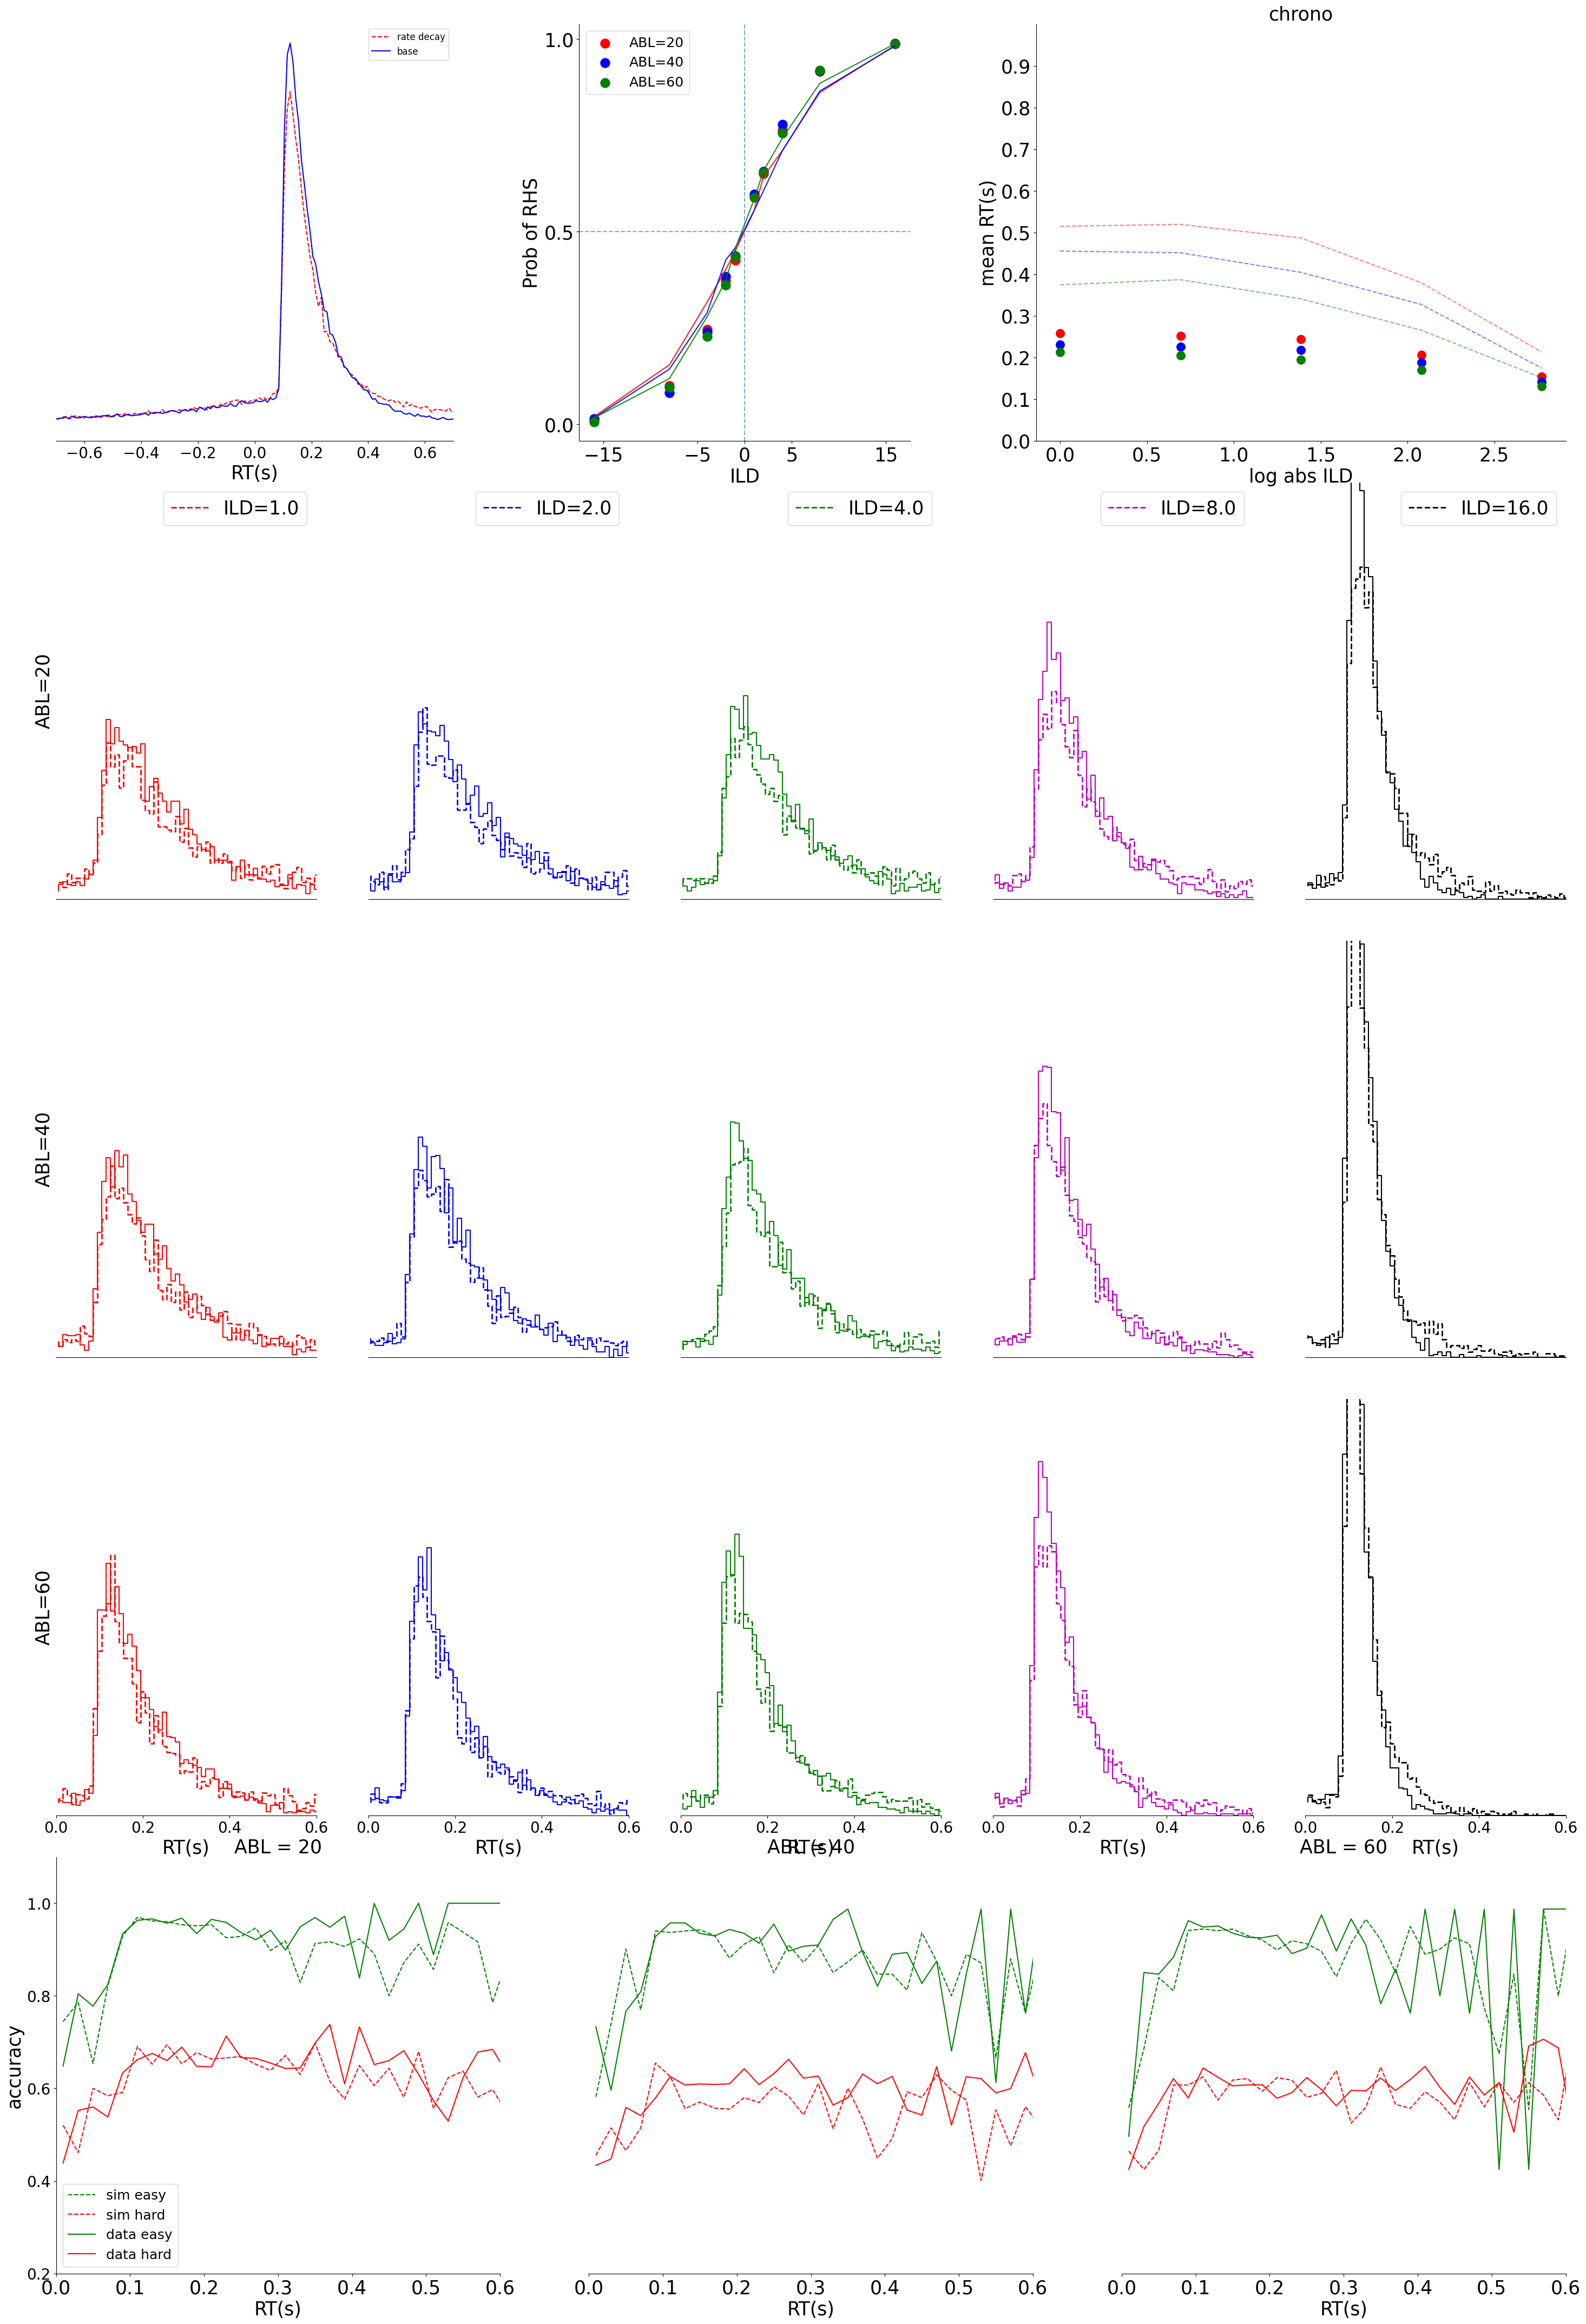

In [14]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1)

# --- 1) Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
    # subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    # wspace=0.09
)

# --- 2) Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

# 0 -grand RTD
bins = np.arange(-1, 1, 0.01)
x, y = sim_diagnose_obj.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='rate decay', ls='--', color='r')

x, y = sim_diagnose_base_obj.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='base', color='b')

# ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-0.7, 0.7)

# 1 - psycho 
data_psycho = sim_diagnose_obj_base_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
sim_psycho = sim_diagnose_obj_valid.plot_psycho()
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])
ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob of RHS', fontsize=25)
# ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.set_xticks([-15, -5, 0, 5, 15])
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0, 0.5, 1.0])
ax_psy.axvline(0, linestyle='--', alpha=0.6)
ax_psy.axhline(0.5, linestyle='--', alpha=0.6)




# 2  - chrono
x, sim_chrono = sim_diagnose_obj_valid.plot_chrono()
for ABL in sim_chrono.keys():
    ax_chrono.plot(np.log(x), sim_chrono[ABL], color=ABL_colors[ABL], alpha=0.5, ls='--')

x, data_chrono = sim_diagnose_obj_base_valid.plot_chrono()
for ABL in data_chrono.keys():
    ax_chrono.scatter(np.log(x), data_chrono[ABL], label=f'data ABL={ABL}', color=ABL_colors[ABL], marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel('log abs ILD', fontsize=25)
ax_chrono.set_ylabel('mean RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.set_ylim(0, 1)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_yticks(np.arange(0, 1, 0.1))

# RTDs per ABL
pos_ILD = all_ILD[all_ILD > 0]
bins = np.arange(0, 1, 0.01)
row = 0

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    ABL = ABL_arr[a]
    for j, ILD in enumerate(pos_ILD):
        ax = fig.add_subplot(gs[row, j])  

        sim_pd = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin([ILD, -ILD]))]
        sim_rt = sim_pd['rt'] - sim_pd['t_stim']

        data_pd = sim_results_pd_valid_base_1[ (sim_results_pd_valid_base_1['ABL'] == ABL) & (sim_results_pd_valid_base_1['ILD'].isin([ILD, -ILD]))]
        data_rt = data_pd['rt'] - data_pd['t_stim']

        sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
        t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
        ax.step(t_pts,sim_rt_hist, linestyle='dashed', color=ILD_colors[ILD], label='rate decay', linewidth=2)

        data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
        ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color=ILD_colors[ILD])

        if a == len(ABL_arr) - 1:
            ax.set_xlabel('RT(s)', fontsize=25)
        if j == 0:
            ax.set_ylabel(f'ABL={ABL}', fontsize=25)
            ax.tick_params(axis='y', which='major', labelsize=20)
        
        if a == 0:
            ax.legend([f'ILD={ILD}'], fontsize=25)

        # ax.legend(fontsize=18) # title covers it
        ax.set_xlim(0, 0.6)
        ax.set_ylim(0, 11)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(True)

        if j != 0:
            ax.spines['left'].set_visible(False)
        ax.set_yticks([])

        if a == len(ABL_arr) - 1:
            ax.tick_params(axis='both', which='major', labelsize=20)
        else:
            ax.set_xticks([])
    
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
bins = np.arange(0, 1, 0.02)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = sim_results_pd_valid_base_1[ (sim_results_pd_valid_base_1['ABL'] == ABL) & (sim_results_pd_valid_base_1['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = sim_results_pd_valid_base_1[ (sim_results_pd_valid_base_1['ABL'] == ABL) & (sim_results_pd_valid_base_1['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 0.6)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)



# Multiple decay rates and RTDs

In iter_num: 0, ABL: 60, ILD: 16.0, t_stim: 0.2788518677745
In iter_num: 0, ABL: 40, ILD: 1.0, t_stim: 0.2788518677745
In iter_num: 0, ABL: 60, ILD: -8.0, t_stim: 0.2788518677745
In iter_num: 0, ABL: 60, ILD: 4.0, t_stim: 0.2788518677745
In iter_num: 0, ABL: 40, ILD: 1.0, t_stim: 0.2788518677745
In iter_num: 0, ABL: 20, ILD: 16.0, t_stim: 0.2788518677745
In iter_num: 0, ABL: 40, ILD: -1.0, t_stim: 0.2788518677745
In iter_num: 0, ABL: 60, ILD: 4.0, t_stim: 0.2788518677745


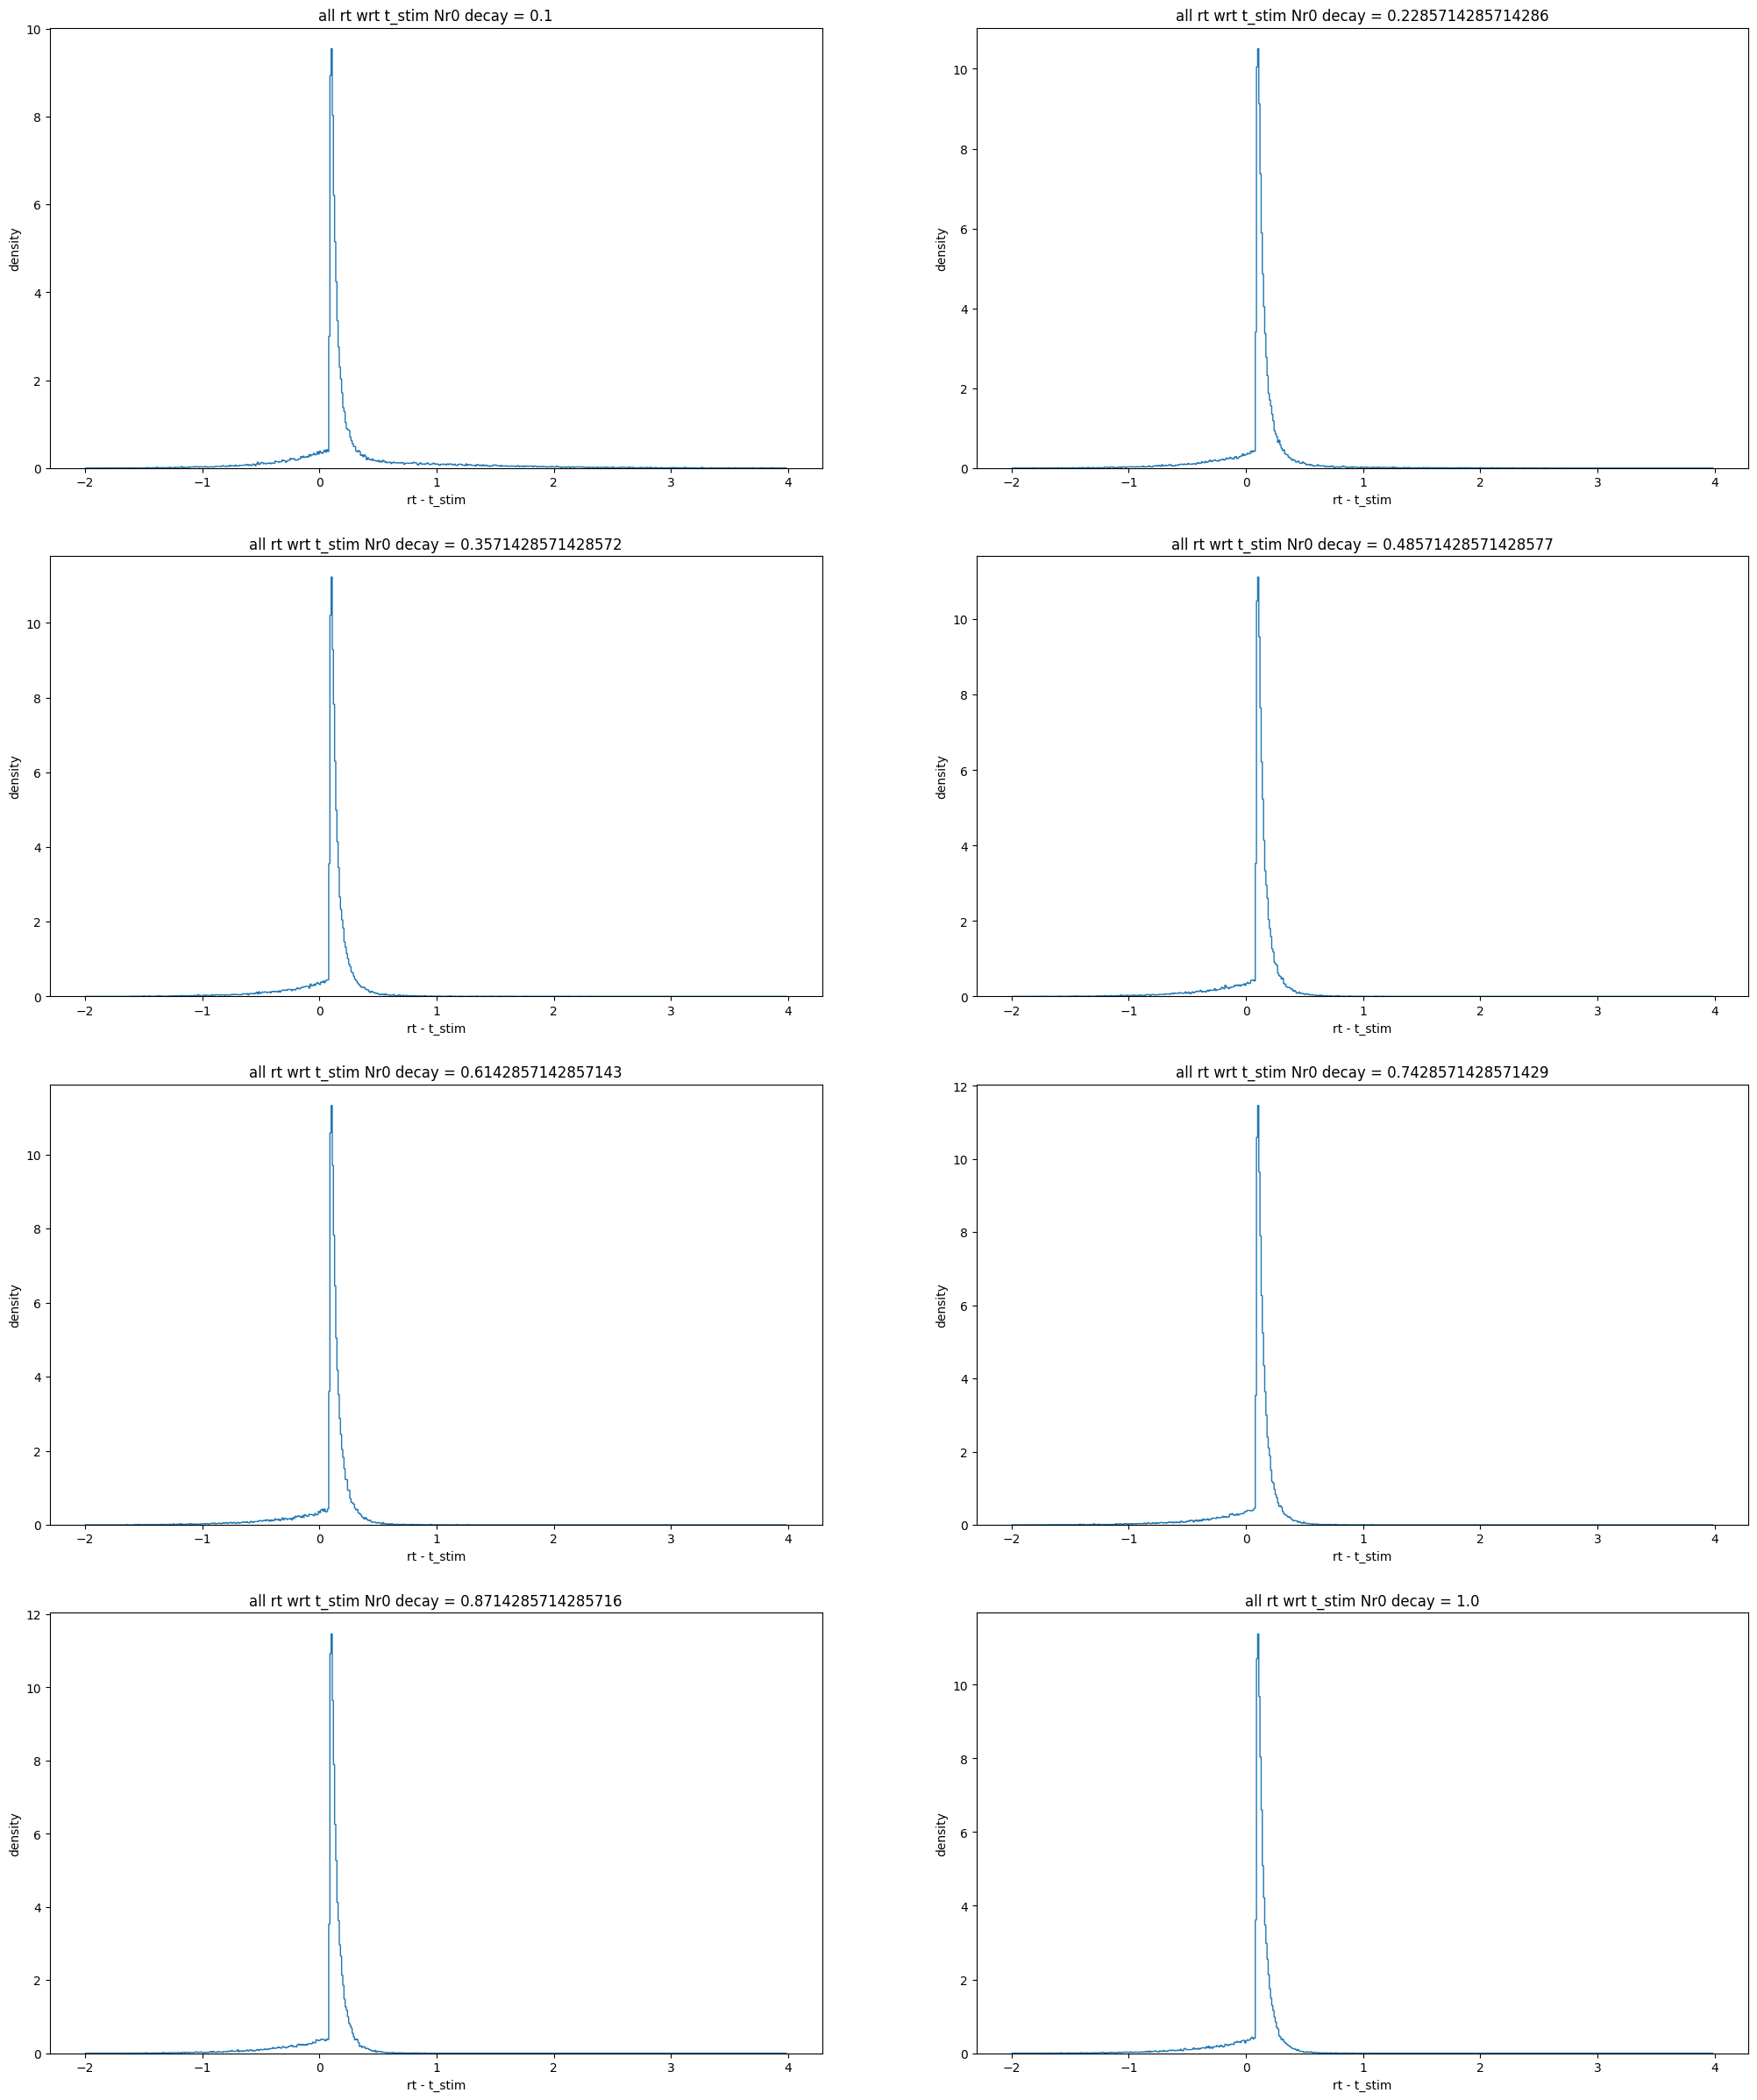

In [4]:
# decay_values = [0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.5, 2]
decay_values = np.linspace(0.1, 1, 8)

f = 1
N_sim = int(50e3)
N_print = int(1e6 + 1)
dt = 1e-3; dB = np.sqrt(dt);
t_stim_sampled = np.random.choice(df['intended_fix'], N_sim)
bins = np.arange(-2,4, 0.01)

plt.figure(figsize=(25,30))
for decay in decay_values:
    T_0_tau = decay
    L = 1
    sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V4)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T0, T_0_tau, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 
    rt = [res['rt'] - res['t_stim'] for res in sim_results if not ( res['rt'] < res['t_stim'] and res['rt'] < 0.3 )]
    plt.subplot(4,2,f)
    plt.hist(rt, bins=bins, density=True, histtype='step');
    plt.xlabel('rt - t_stim')
    plt.ylabel('density')
    plt.title(f'all rt wrt t_stim Nr0 decay = {T_0_tau}')
    f += 1


In [ ]:
x = np.linspace

# rough 

Text(0, 0.5, 'Nr(t)')

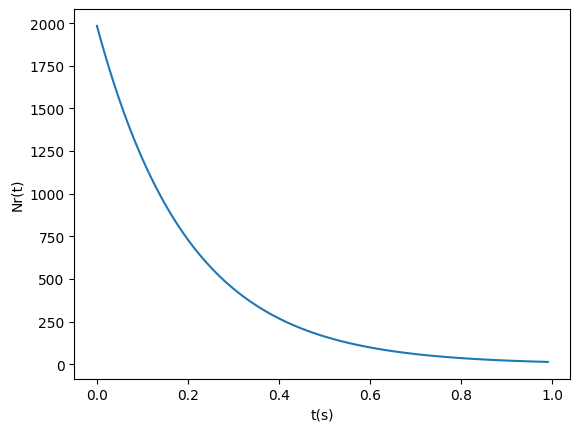

In [15]:
Nr0 = 1/T0

t_pts = np.arange(0, 1, 0.01)


tau = 0.2
Nrt = Nr0 * np.exp(-t_pts/tau)
Tt = 1/Nrt
# plt.plot(t_pts, Tt)
# plt.show()
plt.plot(t_pts, Nrt)
plt.xlabel('t(s)')
plt.ylabel('Nr(t)')